In [ ]:
# 데이터 개수 불균형 문제 해결 전략
# 우선 TOOL을 제외한 3개부터학습
# 남은 O태그를 B-TOOL로 전환하기 전, 필터링 사전 활용 (TECH DICTIONARY - TECHNICAL TAGS 칼럼 이용 혹은 technical_element.csv의 name과 synonym 리스트에 포함된 경우, B-TOOL로 변환)


In [ ]:
# 구글 마운트 사용 X

In [ ]:
# 데이터 로드 (코드 실행 상태 초기화로 인해 파일 다시 로드)
import pandas as pd

file_path = "/content/technical_element_labeled.csv"
df_tech = pd.read_csv(file_path, encoding="utf-8-sig")

# synonym 개수 계산 (쉼표로 구분된 리스트를 개별 요소로 분리)
df_tech["synonym_count"] = df_tech["synonym"].fillna("").apply(lambda x: len(x.split(",")) if x else 0)

# name과 synonym을 합쳐서 총 개수 계산
df_tech["total_count"] = 1 + df_tech["synonym_count"]

# ner_label별 개수 집계
ner_label_counts = df_tech.groupby("ner_label")["total_count"].sum()

print(ner_label_counts)

ner_label
B-FRAME    147
B-LANG      99
B-LIB      114
B-TOOL     361
Name: total_count, dtype: int64


# 1. 작업에 필요한 라이브러리 설치 및 호출

In [1]:
!pip install transformers seqeval[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=13d860b0669c24f7cb1c4edc3339774ff77bffb2586a47d9a1466d32fcee9bce
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
!pip install datasets seqeval torch scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report

In [4]:
# 작업 환경 확인하기 - 가급적이면 GPU
from torch import cuda

# 모델이 GPU에서 실행 중이면, GPU로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# 1-1. ner 태그 미리 준비 완료 (중복 제거 x) - 증강 작업을 위한 정확한 ner 태그 개수 확인 필요

In [ ]:
import pandas as pd

# ✅ 파일 로드
final_file = "/content/final_mapped_technicalTags.csv"
df = pd.read_csv(final_file)

# ✅ 중복 제거 (기술명 & NER 태그 조합 기준)
df_unique = df.drop_duplicates(subset=["mapped_technicalTags"])

# ✅ 각 NER 태그별 개수 계산
ner_counts = df_unique["mapped_technicalTags"].apply(lambda x: eval(x)[1]).value_counts()

# ✅ 결과 저장
output_path = "/content/final_unique_mapped_technicalTags.csv"
df_unique.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ 중복 제거 완료! 저장 경로: {output_path}")
print("🔹 NER 태그별 개수:\n", ner_counts)


✅ 중복 제거 완료! 저장 경로: /content/final_unique_mapped_technicalTags.csv
🔹 NER 태그별 개수:
 mapped_technicalTags
B-TOOL             371
B-FRAME            171
B-LANG              72
B-LIB               72
O-TERM               5
O-TECH               2
O-TECH (기술           2
B-BLOCKCHAIN         1
O\n---\nB-TOOL       1
O 보안 B-LIB           1
O-PLAIN              1
O (기술 용어가            1
B-DISORDER           1
O\n    - B-TOOL      1
O-TOOL               1
Name: count, dtype: int64


In [ ]:
# 원본 개수는 아래와 같다
ner_label
B-FRAME    147
B-LANG      99
B-LIB      114
B-TOOL     361
Name: total_count, dtype: int64

In [ ]:
import pandas as pd

# ✅ 파일 로드
tech_labels_file = "/content/technical_element_labeled.csv"
mapped_tags_file = "/content/final_unique_mapped_technicalTags.csv"

tech_df = pd.read_csv(tech_labels_file)
mapped_df = pd.read_csv(mapped_tags_file)

# ✅ 각 파일에서 사용된 NER 태그 확인
tech_ner_tags = set(tech_df["ner_label"].unique())  # 원본 기술 라벨 태그
mapped_ner_tags = set(mapped_df["mapped_technicalTags"].apply(lambda x: eval(x)[1]))  # 매핑된 태그

# ✅ 누락된 태그 확인
missing_tags = tech_ner_tags - mapped_ner_tags

# ✅ 결과 출력
print("🔹 원본 NER 태그 개수:", len(tech_ner_tags))
print("🔹 매핑된 NER 태그 개수:", len(mapped_ner_tags))
print("❌ 누락된 NER 태그:", missing_tags)


🔹 원본 NER 태그 개수: 4
🔹 매핑된 NER 태그 개수: 15
❌ 누락된 NER 태그: set()


In [ ]:
# 아래는 이상한 결과값 초래

In [ ]:
import pandas as pd

# ✅ 파일 로드
technical_file = "/content/technical_element_labeled.csv"
mapped_file = "/content/final_unique_mapped_technicalTags.csv"

tech_df = pd.read_csv(technical_file)
mapped_df = pd.read_csv(mapped_file)

# ✅ NER 태그 목록 (유효한 태그만 유지)
valid_ner_labels = {"B-TOOL", "B-FRAME", "B-LANG", "B-LIB"}

# ✅ 불필요한 태그 제거
filtered_mapped_df = mapped_df[mapped_df["mapped_technicalTags"].apply(lambda x: eval(x)[1] in valid_ner_labels)]

# ✅ 부족한 데이터 확인 (B-LANG & B-LIB)
missing_lang_count = 99 - len(filtered_mapped_df[filtered_mapped_df["mapped_technicalTags"].apply(lambda x: eval(x)[1] == "B-LANG")])
missing_lib_count = 114 - len(filtered_mapped_df[filtered_mapped_df["mapped_technicalTags"].apply(lambda x: eval(x)[1] == "B-LIB")])

print(f"🔹 B-LANG 추가 필요 개수: {missing_lang_count}")
print(f"🔹 B-LIB 추가 필요 개수: {missing_lib_count}")

# ✅ 부족한 개수만큼 기존 데이터에서 랜덤 샘플링하여 추가
additional_lang = tech_df[tech_df["ner_label"] == "B-LANG"].sample(missing_lang_count, replace=True)
additional_lib = tech_df[tech_df["ner_label"] == "B-LIB"].sample(missing_lib_count, replace=True)

# ✅ 증강된 데이터 추가
augmented_df = pd.concat([filtered_mapped_df, additional_lang, additional_lib])

# ✅ 최종 데이터 저장
final_output_path = "/content/final_balanced_mapped_technicalTags.csv"
augmented_df.to_csv(final_output_path, index=False, encoding="utf-8-sig")
print(f"✅ 불균형 해결 완료! 저장 경로: {final_output_path}")


🔹 B-LANG 추가 필요 개수: 27
🔹 B-LIB 추가 필요 개수: 42
✅ 불균형 해결 완료! 저장 경로: /content/final_balanced_mapped_technicalTags.csv


In [ ]:
# 증강 작업한 기술 용어 사전을 원본 기술 사전의 파일 내용 형식과 맞게 변환 작업
final_unique_mapped_technicalTags.csv 파일을 읽고, mapped_technicalTags 칼럼의 내용을 (seq, category, name, ner_label) 순으로 정리하여 변환

In [ ]:
# 파일 경로 로드 (재업로드 필요)
file_path = "/content/final_unique_mapped_technicalTags.csv"

# 데이터 로드
df = pd.read_csv(file_path)

# mapped_technicalTags 칼럼에서 (name, ner_label) 분리
df[["name", "ner_label"]] = df["mapped_technicalTags"].apply(eval).apply(pd.Series)

# NER 태그에 따라 category 지정
category_mapping = {
    "B-LANG": "language",
    "B-FRAME": "framework",
    "B-LIB": "library",
    "B-TOOL": "tool"
}

df["category"] = df["ner_label"].map(category_mapping)

# language → framework → library → tool 순서로 정렬
category_order = ["language", "framework", "library", "tool"]
df_sorted = df[df["category"].notna()].sort_values(by="category", key=lambda x: x.map({cat: i for i, cat in enumerate(category_order)}))

# seq 번호 부여
df_sorted.insert(0, "seq", range(len(df_sorted)))

# 필요한 컬럼 선택
df_final = df_sorted[["seq", "category", "name", "ner_label"]]

# 저장
output_path = "/content/final_mapped_ner_labels_technicalTags.csv"
df_final.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"✅ 원본 ner 라벨 태그에 맞게 변환 작업: {output_path}")


✅ 원본 ner 라벨 태그에 맞게 변환 작업: /content/final_mapped_ner_labels_technicalTags.csv


In [ ]:
import pandas as pd

# 파일 경로
file_path = "/content/final_mapped_ner_labels_technicalTags.csv"

# CSV 파일 로드
df = pd.read_csv(file_path, encoding="utf-8-sig")

# NER 태그별 개수 세기
ner_counts = df["ner_label"].value_counts()

# 결과 출력
print("🔹 NER 태그별 개수:")
print(ner_counts)


🔹 NER 태그별 개수:
ner_label
B-TOOL     371
B-FRAME    171
B-LANG      72
B-LIB       72
Name: count, dtype: int64


In [ ]:
import pandas as pd

# 파일 경로
original_file = "/content/technical_element_labeled.csv"
new_file = "/content/final_mapped_ner_labels_technicalTags.csv"

# CSV 파일 로드
df_original = pd.read_csv(original_file, encoding="utf-8-sig")
df_new = pd.read_csv(new_file, encoding="utf-8-sig")

# 원본 데이터 NER 태그 개수 계산
original_counts = df_original["ner_label"].value_counts().sort_index()

# 새로운 데이터 NER 태그 개수 계산
new_counts = df_new["ner_label"].value_counts().sort_index()

# 두 개의 데이터프레임을 비교하여 개수 차이 확인
comparison_df = pd.DataFrame({"original_count": original_counts, "new_count": new_counts}).fillna(0)
comparison_df["difference"] = comparison_df["new_count"] - comparison_df["original_count"]

# 차이점 확인
print("✅ 원본과 새로운 데이터의 NER 태그 개수 차이:")
print(comparison_df)


✅ 원본과 새로운 데이터의 NER 태그 개수 차이:
           original_count  new_count  difference
ner_label                                       
B-FRAME                54        171         117
B-LANG                 35         72          37
B-LIB                  48         72          24
B-TOOL                141        371         230


In [ ]:
import pandas as pd

# 파일 경로
original_file = "/content/technical_element_labeled.csv"
new_file = "/content/final_mapped_ner_labels_technicalTags.csv"

# CSV 파일 로드
df_original = pd.read_csv(original_file, encoding="utf-8-sig")
df_new = pd.read_csv(new_file, encoding="utf-8-sig")

# 원본과 새로운 데이터의 'name' 컬럼에서 차이점 찾기
original_names = set(df_original["name"].str.lower().str.strip())  # 소문자 변환 및 공백 제거
new_names = set(df_new["name"].str.lower().str.strip())

# 새로운 데이터에만 존재하는 기술명 찾기
new_only_names = new_names - original_names

# 새로운 기술들만 필터링
new_technologies_df = df_new[df_new["name"].str.lower().str.strip().isin(new_only_names)]

# 결과 출력
print(f"✅ 원본에 없고 새로운 데이터에 추가된 기술 개수: {len(new_only_names)} 개")
print("🔹 새롭게 추가된 기술 목록:")
print(new_technologies_df)


✅ 원본에 없고 새로운 데이터에 추가된 기술 개수: 549 개
🔹 새롭게 추가된 기술 목록:
     seq  category                       name ner_label
1      1  language                  하드웨어 아키텍처    B-LANG
3      3  language                objective-c    B-LANG
4      4  language                        mac    B-LANG
5      5  language            shell scripting    B-LANG
6      6  language                 embedded c    B-LANG
..   ...       ...                        ...       ...
681  681      tool                   통계 자료 분석    B-TOOL
682  682      tool                     데이터 분석    B-TOOL
683  683      tool  google container registry    B-TOOL
684  684      tool                      figma    B-TOOL
685  685      tool         google tag manager    B-TOOL

[577 rows x 4 columns]


# 1-2. 원본에는 없고, 새롭게 추가된 기술 (ner 태그) : technical_element_labeled 형식에 맞게 컬럼 변환 완료(seq, category, name, ner_label 순)

In [ ]:
import pandas as pd

# 파일 경로
original_file = "/content/technical_element_labeled.csv"
new_file = "/content/final_mapped_ner_labels_technicalTags.csv"

# CSV 파일 로드
df_original = pd.read_csv(original_file, encoding="utf-8-sig")
df_new = pd.read_csv(new_file, encoding="utf-8-sig")

# 원본과 새로운 데이터의 'name' 컬럼에서 차이점 찾기
original_names = set(df_original["name"].str.lower().str.strip())  # 소문자 변환 및 공백 제거
new_names = set(df_new["name"].str.lower().str.strip())

# 새로운 데이터에만 존재하는 기술명 찾기
new_only_names = new_names - original_names

# 새로운 기술들만 필터링
new_technologies_df = df_new[df_new["name"].str.lower().str.strip().isin(new_only_names)]

# 결과를 CSV 파일로 저장
output_file = "/content/newly_added_technical_element_labeled.csv"
new_technologies_df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"✅ 새롭게 추가된 기술 개수: {len(new_only_names)} 개")
print(f"✅ CSV 파일 저장 완료: {output_file}")


✅ 새롭게 추가된 기술 개수: 549 개
✅ CSV 파일 저장 완료: /content/newly_added_technical_element_labeled.csv


In [ ]:
import pandas as pd

# 새롭게 추가된 기술 목록 CSV 파일 로드
new_technologies_file = "/content/newly_added_technical_element_labeled.csv"
df_new_tech = pd.read_csv(new_technologies_file, encoding="utf-8-sig")

# NER 태그별 개수 카운트
ner_tag_counts = df_new_tech["ner_label"].value_counts()

# 결과 출력
print("🔹 새롭게 추가된 기술들의 NER 태그별 개수:")
print(ner_tag_counts)


🔹 새롭게 추가된 기술들의 NER 태그별 개수:
ner_label
B-TOOL     322
B-FRAME    150
B-LIB       57
B-LANG      48
Name: count, dtype: int64


In [ ]:
# 원본 개수는 아래와 같다
ner_label
B-TOOL     361
B-FRAME    147
B-LIB      114
B-LANG      99
Name: total_count, dtype: int64

# 1-3. 원본 ner 라벨 태그에서 synonym 칼럼 제거하고, 실제 학습 진행 후 자동 분류 확인 예정

In [ ]:
직접 csv 파일 열어서 synonym 칼럼을 마우스 우클릭 > 컬럼 삭제 해버리면 csv 파일 자체가 열이 밀려버린다.

In [ ]:
import pandas as pd

# 파일 경로 설정
input_file = "/content/technical_element_labeled.csv"
output_file = "/content/technical_element_labeled2.csv"

# CSV 파일 로드
df = pd.read_csv(input_file, encoding="utf-8-sig")

# synonym 칼럼 삭제
df.drop(columns=["synonym"], inplace=True, errors='ignore')

# 결과를 새로운 CSV 파일로 저장
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"✅ 'synonym' 칼럼 제거 완료! 저장 경로: {output_file}")


✅ 'synonym' 칼럼 제거 완료! 저장 경로: /content/technical_element_labeled2.csv


# 1-4. morpheme_eng 칼럼에서 작업 테스트 진행하기

In [ ]:
# 이찬님 작업 코드
# 2025-01-24-12_categorized.csv 파일


# 1-4-1. ner 태그 개수 증강 전략

In [ ]:
import pandas as pd

# 파일 경로
original_file = "/content/technical_element_labeled2.csv"  # 원본 데이터
new_data_file = "/content/newly_added_technical_element_labeled.csv"  # 새로 추가된 기술 데이터
balanced_output_file = "/content/balanced_ner_dataset.csv"  # 최종 균형 잡힌 NER 데이터

# CSV 파일 로드
df_original = pd.read_csv(original_file, encoding="utf-8-sig")
df_new = pd.read_csv(new_data_file, encoding="utf-8-sig")

# NER 태그별 개수 확인 (원본 데이터)
tag_counts = df_original["ner_label"].value_counts()
print("🔹 원본 데이터 NER 태그별 개수:\n", tag_counts)

# 🚀 데이터 증강 (태그 불균형 해결)
target_count = tag_counts.max()  # 가장 많은 태그 개수를 기준으로 맞춤
balanced_df = df_original.copy()

# 태그별로 부족한 개수만큼 복제하여 균형 맞추기
for tag, count in tag_counts.items():
    if count < target_count:
        needed_samples = target_count - count  # 부족한 개수 계산
        sampled_data = df_original[df_original["ner_label"] == tag].sample(n=needed_samples, replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, sampled_data], ignore_index=True)

# 🔹 새로운 기술 데이터 추가
balanced_df = pd.concat([balanced_df, df_new], ignore_index=True)

# ✅ 균형 잡힌 NER 데이터 개수 확인
balanced_tag_counts = balanced_df["ner_label"].value_counts()
print("✅ 균형 조정 후 NER 태그별 개수:\n", balanced_tag_counts)

# 📌 균형 잡힌 데이터 저장
balanced_df.to_csv(balanced_output_file, index=False, encoding="utf-8-sig")
print(f"✅ 균형 잡힌 데이터 저장 완료! 저장 경로: {balanced_output_file}")


🔹 원본 데이터 NER 태그별 개수:
 ner_label
B-TOOL     141
B-FRAME     54
B-LIB       48
B-LANG      35
Name: count, dtype: int64
✅ 균형 조정 후 NER 태그별 개수:
 ner_label
B-TOOL     463
B-FRAME    291
B-LIB      198
B-LANG     189
Name: count, dtype: int64
✅ 균형 잡힌 데이터 저장 완료! 저장 경로: /content/balanced_ner_dataset.csv


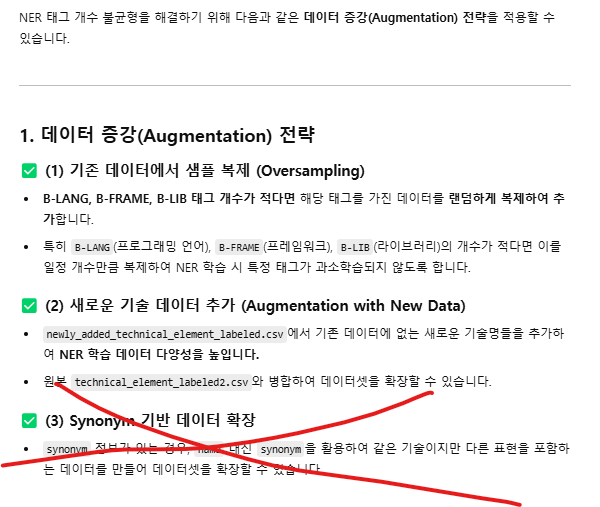

In [5]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report

In [6]:
# 📌 파일 경로
TRAIN_DATA = "/content/balanced_ner_dataset.csv"  # 균형 잡힌 학습 데이터
MODEL_NAME = "bert-base-multilingual-cased"  # 다국어 BERT 모델

# 🔹 데이터 로드
df = pd.read_csv(TRAIN_DATA, encoding="utf-8-sig")

# 🔹 BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# 🔹 NER 태그 매핑
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 전처리 함수 (토큰화 + NER 라벨 인코딩)
def preprocess_data(examples):
    tokens = examples["name"].split()
    labels = examples["ner_label"].split()

    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    input_length = len(inputs["input_ids"])

    # ✅ labels의 길이를 input_ids와 동일하도록 설정
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (input_length - len(label_ids))
    label_ids = label_ids[:input_length]

    inputs["labels"] = label_ids

    return inputs

# 🔹 Hugging Face Dataset 변환
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

In [7]:
import pandas as pd
from transformers import BertTokenizer

# 🔹 파일 경로 설정
TRAIN_DATA_PATH = "/content/balanced_ner_dataset.csv"
OUTPUT_TRAIN_PATH = "/content/ner4_training_data.csv"

# 🔹 BERT 토크나이저 로드
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 🔹 데이터 로드
df = pd.read_csv(TRAIN_DATA_PATH, encoding="utf-8-sig")

# 🔹 WordPiece 토큰화 및 NER 라벨 적용
wordpiece_tokens_list = []
ner_labels_list = []

for _, row in df.iterrows():
    words = [row["name"].lower()]  # name 컬럼 (기본 단어)
    #if pd.notna(row["synonym"]):  # Synonym이 있으면 추가
     #   words.extend([syn.strip().lower() for syn in row["synonym"].split(",")])

    for word in words:
        tokens = tokenizer.tokenize(word)  # WordPiece 토큰화
        ner_label = row["ner_label"]  # 이미 부여된 NER 라벨

        wordpiece_tokens_list.append(" ".join(tokens))
        ner_labels_list.append(" ".join([ner_label] * len(tokens)))  # 모든 워드피스에 동일한 라벨 적용

# 🔹 새로운 데이터프레임 생성
train_df = pd.DataFrame({
    "wordpiece_tokens": wordpiece_tokens_list,
    "ner_labels": ner_labels_list
})

# 🔹 저장
train_df.to_csv(OUTPUT_TRAIN_PATH, index=False, encoding="utf-8-sig")


print(f"✅ WordPiece 기반 NER 훈련 데이터 생성 완료! 파일 저장: {OUTPUT_TRAIN_PATH}")


✅ WordPiece 기반 NER 훈련 데이터 생성 완료! 파일 저장: /content/ner4_training_data.csv


In [8]:
import torch
from datasets import Dataset

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 전처리 함수
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_labels"].split()

    # ✅ 토큰화를 실행하고 padding & truncation 적용
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    # ✅ 실제 토큰 길이 가져오기
    input_length = len(inputs["input_ids"])

    # ✅ labels의 길이를 input_ids와 동일하도록 설정
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (input_length - len(label_ids))
    label_ids = label_ids[:input_length]

    inputs["labels"] = label_ids
    return inputs

# 🔹 Dataset 변환 및 전처리
dataset = Dataset.from_pandas(train_df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

In [9]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments

# 🔹 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir="./ner4_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# 🔹 BERT 모델 초기화 (NER 태그 개수 지정)
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))

# 🔹 Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# 🔹 모델 학습 시작
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-08e615e7f6a8>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cgygy8989 (cgygy8989-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.008700,0.008169
2,0.009600,0.007624
3,0.007600,0.007695


TrainOutput(global_step=684, training_loss=0.012260788940002171, metrics={'train_runtime': 507.0393, 'train_samples_per_second': 5.396, 'train_steps_per_second': 1.349, 'total_flos': 714927316746240.0, 'train_loss': 0.012260788940002171, 'epoch': 3.0})

In [10]:
import torch

# 모델이 GPU에서 실행 중이면, GPU로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [15]:
import os

model_path = "/content/ner4_model"
if os.path.exists(model_path):
    print("✅ 모델 디렉토리가 존재합니다.")
    print("📂 저장된 파일 목록:", os.listdir(model_path))
else:
    print("❌ 모델 디렉토리가 존재하지 않습니다. 다시 훈련 후 저장이 필요합니다.")


✅ 모델 디렉토리가 존재합니다.
📂 저장된 파일 목록: ['checkpoint-456', 'checkpoint-228', 'checkpoint-684']


In [16]:
# ✅ 훈련된 모델 저장
trainer.save_model("/content/ner4_model")
tokenizer.save_pretrained("/content/ner4_model")

print("✅ 모델 저장 완료!")


✅ 모델 저장 완료!


In [18]:
import pandas as pd
import torch
import os
from transformers import BertTokenizer, BertForTokenClassification
from seqeval.metrics import classification_report

# 📌 파일 경로
TEST_DATA_PATH = "/content/combined_morpheme.csv"  # 예측할 테스트 데이터

# 🔹 학습된 모델 로드
MODEL_PATH = "/content/ner4_model"
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForTokenClassification.from_pretrained(MODEL_PATH)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {i: label for i, label in enumerate(ner_labels)}

# 🔹 테스트 데이터 로드
df_test = pd.read_csv(TEST_DATA_PATH, encoding="utf-8-sig")

# ✅ 모델 예측 수행 함수
def predict_ner(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] if idx.item() < len(ner_labels) else "O" for idx in predictions[0]]

    return tokens, predicted_labels

# ✅ 모든 데이터에 대해 예측 수행
df_test["tokens"], df_test["predicted_labels"] = zip(*df_test["combined_morpheme"].apply(predict_ner))

# 🔹 평가 수행 (정답과 비교)
if "ner_label" in df_test.columns:  # 정답이 포함된 경우
    true_labels = df_test["ner_label"].apply(lambda x: x.split())  # 실제 정답 라벨
    pred_labels = df_test["predicted_labels"].apply(lambda x: x)

    # 🔥 평가 지표 출력
    print("\n🔹 NER 평가 결과:\n", classification_report(true_labels.tolist(), pred_labels.tolist(), digits=4))

# ✅ 예측 결과 저장
OUTPUT_FILE = "/content/ner4_predicted_results.csv"
df_test.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
print(f"✅ 예측 완료 및 저장: {OUTPUT_FILE}")


✅ 예측 완료 및 저장: /content/ner4_predicted_results.csv


In [ ]:
# 이번에는 외래어만 추출한 것으로 테스트

In [20]:
import pandas as pd
import torch
import os
from transformers import BertTokenizer, BertForTokenClassification
from seqeval.metrics import classification_report

# 📌 파일 경로
TEST_DATA_PATH = "/content/filtered_foreign_words.csv"  # 예측할 테스트 데이터

# 🔹 학습된 모델 로드
MODEL_PATH = "/content/ner4_model"
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForTokenClassification.from_pretrained(MODEL_PATH)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {i: label for i, label in enumerate(ner_labels)}

# 🔹 테스트 데이터 로드
df_test = pd.read_csv(TEST_DATA_PATH, encoding="utf-8-sig")

# ✅ 모델 예측 수행 함수
def predict_ner(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] if idx.item() < len(ner_labels) else "O" for idx in predictions[0]]

    return tokens, predicted_labels

# ✅ 모든 데이터에 대해 예측 수행
df_test["tokens"], df_test["predicted_labels"] = zip(*df_test["foreign_only"].apply(predict_ner))

# 🔹 평가 수행 (정답과 비교)
if "ner_label" in df_test.columns:  # 정답이 포함된 경우
    true_labels = df_test["ner_label"].apply(lambda x: x.split())  # 실제 정답 라벨
    pred_labels = df_test["predicted_labels"].apply(lambda x: x)

    # 🔥 평가 지표 출력
    print("\n🔹 NER 평가 결과:\n", classification_report(true_labels.tolist(), pred_labels.tolist(), digits=4))

# ✅ 예측 결과 저장
OUTPUT_FILE = "/content/ner4-1_predicted_results.csv"
df_test.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")
print(f"✅ 예측 완료 및 저장: {OUTPUT_FILE}")


✅ 예측 완료 및 저장: /content/ner4_predicted_results.csv


# 아래 내용 무시하기 - 위 작업까지 고려(NER 태그 개수 균등 작업 완료)

# ner_training_data를 2개 만들기 (3개 학습, 나머지 1개 tool학습)

In [ ]:
import pandas as pd

# CSV 파일 로드
technical_df = pd.read_csv("/content/technical_element_labeled.csv", encoding="utf-8-sig")

# 라벨 개수 확인 (불균형 문제 체크) - 일반 대표어 기준(name)
print("🔹 NER 라벨 개수 분포:\n", technical_df["ner_label"].value_counts())


🔹 NER 라벨 개수 분포:
 ner_label
B-TOOL     141
B-FRAME     54
B-LIB       48
B-LANG      35
Name: count, dtype: int64


In [ ]:
# ner 학습 데이터 준비(3개) - tool 제외

In [ ]:
from transformers import BertTokenizer

# BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# 🔹 B-TOOL 제외한 데이터셋 필터링
filtered_technical_df = technical_df[technical_df["ner_label"].isin(["B-LANG", "B-FRAME", "B-LIB"])].copy()

# 🔹 WordPiece 토크나이징 수행
filtered_technical_df["wordpiece_tokens"] = filtered_technical_df["name"].apply(lambda x: " ".join(tokenizer.tokenize(str(x))))

# 🔹 CSV 저장 (NER 훈련용)
filtered_technical_df.to_csv("/content/ner_train_data1.csv", index=False, encoding="utf-8-sig")
print("✅ NER 학습 데이터 저장 완료: /content/ner_train_data1.csv")


✅ NER 학습 데이터 저장 완료: /content/ner_train_data1.csv


In [ ]:
# trainer로 학습 및 평가

In [ ]:
import torch
from transformers import BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report

# 🔹 NER 태그 정의 (B-TOOL 제외)
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 로드
df = pd.read_csv("/content/ner_train_data1.csv", encoding="utf-8-sig")

# 🔹 데이터 전처리 함수
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_label"].split()

    inputs = tokenizer(tokens, is_split_into_words=True, truncation=True, padding="max_length", max_length=512)
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (512 - len(label_ids))
    label_ids = label_ids[:512]  # 최대 길이 조정
    inputs["labels"] = label_ids
    return inputs

# 🔹 Hugging Face Dataset 변환
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]

# 🔹 BERT 모델 초기화
model = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(ner_labels))

# 🔹 TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./ner1_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

# 🔹 Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# 🔹 학습 시작
trainer.train()

# 🔹 모델 저장
model.save_pretrained("/content/ner1_model")
tokenizer.save_pretrained("/content/ner1_model")
print("✅ 모델 저장 완료")


Map:   0%|          | 0/137 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-a40a2b67f41d>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cgygy8989 (cgygy8989-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.005922
2,No log,0.003373
3,No log,0.002979


✅ 모델 저장 완료


In [ ]:
# 모델이 O 태그로 인식한 것 중 B-TOOL이 맞는 경우 후처리 적용

In [11]:
import torch

# 모델이 GPU에서 실행 중이면, GPU로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [12]:
import torch

# 🔹 예측 수행 함수
def predict_ner(text):
    tokens = tokenizer.tokenize(text)

    # 모델과 같은 디바이스 설정
    device = model.device

    # 입력 데이터 생성 및 디바이스 이동
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt",
                       truncation=True, padding="max_length", max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ✅ 입력 데이터를 모델과 동일한 디바이스로 이동

    with torch.no_grad():
        outputs = model(**inputs)  # 모델 예측

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] if idx.item() < len(ner_labels) else "O" for idx in predictions[0]]

    return tokens, predicted_labels

# 🔹 모델을 올바른 디바이스로 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # ✅ 모델을 GPU 또는 CPU로 이동
print(f"✅ 모델이 {device}에서 실행됩니다.")

# 🔹 모든 외래어 데이터에 대해 NER 예측 수행
foreign_df["tokens"], foreign_df["predicted_labels"] = zip(*foreign_df["foreign_only"].apply(predict_ner))

# 🔹 O 태그 중 실제 tool과 일치하는 경우 B-TOOL로 변경
def apply_tool_tag(row):
    if row["predicted_labels"] == "O" and row["foreign_only"].lower() in list(technical_df[technical_df["ner_label"] == "B-TOOL"]["name"]):
        return "B-TOOL"
    return row["predicted_labels"]

foreign_df["final_predicted_labels"] = foreign_df.apply(apply_tool_tag, axis=1)

# 🔹 예측 결과 저장
foreign_df.to_csv("/content/predicted_ner_results.csv", index=False, encoding="utf-8-sig")
print("✅ 예측 결과 저장 완료")


✅ 모델이 cuda에서 실행됩니다.


NameError: name 'foreign_df' is not defined

In [ ]:
# 전부 o 태그로 인식하여 평가 수행할 필요 x

In [ ]:
from seqeval.metrics import classification_report

# 🔹 모델 예측 데이터 로드
predicted_df = pd.read_csv("/content/predicted_ner_results.csv", encoding="utf-8-sig")

# 🔹 평가 수행
report = classification_report(predicted_df["ner_label"].tolist(), predicted_df["final_predicted_labels"].tolist(), digits=4)
print("🔹 NER 평가 결과:\n", report)


# 2. 2차시도 - 데이터 불균형 문제 (ner_test2.ipynb 결과, 전부 b-tool로 인식)


In [ ]:
# 데이터 증식 해보기 - technicaltags 칼럼 추가해서 4개의 기술 스택에 분류해보기
# /content/merged_df_2025-01-17-16.csv 파일의 technicalTags 칼럼

# 데이터 증식을 위한 매핑 작업
technicalTags 컬럼을 기반으로, 언어(Language), 라이브러리(Library), 프레임워크(Framework), 툴(Tool) 태그로 매핑하는 작업을 수행하겠습니다.

In [ ]:
# 데이터 증식 작업 (merged.csv 파일의 technicalTags 칼럼 값을 ner라벨 값에 맞게 매핑)
# 참고 technicalTags 칼럼 값이므로 outside 태그가 존재 불가

import pandas as pd

# 파일 경로
merged_file_path = "/content/merged_df_2025-01-17-16.csv"
technical_element_file_path = "/content/technical_element_labeled.csv"

try:
    # 데이터 불러오기
    merged_df = pd.read_csv(merged_file_path, encoding="utf-8-sig")
    technical_element_df = pd.read_csv(technical_element_file_path, encoding="utf-8-sig")

    # NER 라벨 매핑 정보
    ner_mapping = {
        "language": "B-LANG",
        "framework": "B-FRAME",
        "library": "B-LIB",
        "tool": "B-TOOL"
    }

    # 기존 기술 요소 매핑 딕셔너리 생성
    tech_dict = {}
    for _, row in technical_element_df.iterrows():
        category = row["category"]  # language, library, framework, tool
        label = ner_mapping.get(category, "O")  # NER 태그 매핑 (없으면 O)

        # name과 synonym을 매핑
        tech_dict[row["name"].lower()] = label
        if pd.notna(row["synonym"]):
            for synonym in row["synonym"].split(","):
                tech_dict[synonym.strip().lower()] = label

    # technicalTags 컬럼의 값을 쉼표(,) 기준으로 분리
    def map_technical_tags(tags):
        if pd.isna(tags):
            return []
        tag_list = [tag.strip().lower() for tag in tags.split(",")]  # 태그를 소문자로 변환 및 리스트화
        return [(tag, tech_dict.get(tag, "O")) for tag in tag_list]  # 매핑된 태그 반환

    # technicalTags 컬럼 매핑 수행
    merged_df["mapped_technicalTags"] = merged_df["technicalTags"].apply(map_technical_tags)

    # 데이터 확인
    mapped_tags_df = merged_df[["technicalTags", "mapped_technicalTags"]].explode("mapped_technicalTags").dropna()

    # 매핑된 데이터프레임 저장
    output_mapped_tags_path = "/content/mapped_technicalTags.csv"
    mapped_tags_df.to_csv(output_mapped_tags_path, index=False, encoding="utf-8-sig")

except FileNotFoundError:
    print("🔴 필요한 파일이 없습니다. CSV 파일을 다시 업로드해주세요.")


In [ ]:
import pandas as pd

# 파일 로드
file_path = "/content/mapped_technicalTags.csv"  # 실제 파일 경로 확인 필요
df = pd.read_csv(file_path, encoding="utf-8-sig")

# 튜플 형태 데이터를 분리하여 새로운 컬럼 생성
df[['tag', 'ner_label']] = df['mapped_technicalTags'].str.extract(r"\('(.+)', '(.+)'\)")

# 각 NER 태그 개수 확인
ner_label_counts = df["ner_label"].value_counts()

# 결과 출력
print(ner_label_counts)


ner_label
O          3822
B-LANG     3160
B-TOOL     2699
B-LIB       766
B-FRAME     645
Name: count, dtype: int64


In [ ]:
# outside 태그가 존재하는 것이 말도 안 되므로
# gpt api 사용하기
# 'O'라고 되어있는 것들만 따로 추출하는 코드 작성 후 해당 파일에서만 ner 태그 분류 작업()
B-LANG
B-TOOL
B-LIB
B-FRAME


In [ ]:
import pandas as pd

# 파일 로드
file_path = "/content/mapped_technicalTags.csv"
df = pd.read_csv(file_path, encoding="utf-8-sig")

# 'O' 태그만 필터링
o_tagged_df = df[df['mapped_technicalTags'].str.contains("'O'")]

# 필터링된 데이터 저장
o_tagged_file_path = "/content/o_tagged_technicalTags.csv"
o_tagged_df.to_csv(o_tagged_file_path, index=False, encoding="utf-8-sig")



technicalTags 칼럼, outside 태그를 ner 태그에 맞게 자동 분류 요청(gpt4 api 사용 - 200원 차감)

In [ ]:
# ✅ OpenAI API 키 설정 (본인 키 입력 필요)


In [ ]:
# 우선 gpt3-5 turbo부터 사용

In [ ]:
import pandas as pd
import openai
import ast
import time

# ✅ OpenAI API 키 설정 (본인 키 입력 필요)

# ✅ 파일 로드
file_path = "/content/o_tagged_technicalTags.csv"
df = pd.read_csv(file_path)

# ✅ 'O' 태그만 추출
o_tag_df = df[df["mapped_technicalTags"].str.contains("'O'")].copy()

# ✅ GPT API 요청 함수
def get_ner_tag(technical_tag):
    prompt = f"""
    다음 IT 기술 용어 '{technical_tag}'에 대해 적절한 Named Entity Recognition (NER) 태그를 부여하세요.
    가능한 태그는 다음과 같습니다:
    - B-LANG (프로그래밍 언어)
    - B-TOOL (개발 도구, 플랫폼, 데이터베이스 등)
    - B-LIB (라이브러리)
    - B-FRAME (프레임워크)

    정확한 태그를 하나만 반환하세요. 설명 없이 태그만 출력하세요.
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "system", "content": "당신은 IT 용어를 분류하는 전문가입니다."},
                      {"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0.0
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"❌ GPT 요청 실패: {e}")
        return "O"

# ✅ 'O' 태그 항목 GPT API로 분류
updated_tags = []
for index, row in o_tag_df.iterrows():
    tag_tuple = ast.literal_eval(row["mapped_technicalTags"])  # 문자열을 튜플로 변환
    tech_tag = tag_tuple[0]  # 기술명 추출
    predicted_ner = get_ner_tag(tech_tag)  # GPT-4 API 호출

    updated_tuple = (tech_tag, predicted_ner)  # 새로운 NER 태그 적용
    updated_tags.append(updated_tuple)

    time.sleep(0.5)  # API 호출 제한 방지를 위해 0.5초 대기

# ✅ 데이터프레임 업데이트
df.loc[df["mapped_technicalTags"].str.contains("'O'"), "mapped_technicalTags"] = [str(tag) for tag in updated_tags]

# ✅ 결과 저장
output_path = "/content/updated_o_tagged_technicalTags.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ GPT API를 사용하여 NER 태그 업데이트 완료! 저장 경로: {output_path}")


✅ GPT API를 사용하여 NER 태그 업데이트 완료! 저장 경로: /content/updated_o_tagged_technicalTags.csv


In [ ]:
#$ 이영배 멘토님 피드백
# 예시 코드 대로 한 번 해봐라
# is_split_into_words=True 값을 주면, 입력 데이터 자체를 이미 분할이 완료된 상태로 주기 때문에 더 이상 분할하지 않는다.


In [ ]:
import pandas as pd

# 파일 로드
file_path = "/content/updated_o_tagged_technicalTags.csv"  # 실제 파일 경로 확인 필요
df = pd.read_csv(file_path, encoding="utf-8-sig")

# 튜플 형태 데이터를 분리하여 새로운 컬럼 생성
df[['tag', 'ner_label']] = df['mapped_technicalTags'].str.extract(r"\('(.+)', '(.+)'\)")

# 각 NER 태그 개수 확인
ner_label_counts = df["ner_label"].value_counts()

# 결과 출력
print(ner_label_counts)


ner_label
B-TOOL             1654
B-FRAME            1624
B-LANG              322
B-LIB               196
O-TECH                5
O-TECH (기술            5
O-TERM                5
B-BLOCKCHAIN          4
O\n---\nB-TOOL        1
O-PLAIN               1
O 보안 B-LIB            1
O (기술 용어가             1
B-DISORDER            1
O\n    - B-TOOL       1
O-TOOL                1
Name: count, dtype: int64


TechnicalTags의 ner 답안 파일 완성

In [ ]:
import pandas as pd
import ast

# ✅ 원본 파일 & 수정된 파일 경로
original_file = "/content/mapped_technicalTags.csv"
updated_o_tagged_file = "/content/updated_o_tagged_technicalTags.csv"

# ✅ 파일 로드
original_df = pd.read_csv(original_file)
updated_o_df = pd.read_csv(updated_o_tagged_file)

# ✅ 'O' 태그가 포함된 행 제거
filtered_original_df = original_df[~original_df["mapped_technicalTags"].str.contains("'O'")].copy()

# ✅ 수정된 'O' 태그 데이터를 추가
merged_df = pd.concat([filtered_original_df, updated_o_df], ignore_index=True)

# ✅ 결과 저장
output_path = "/content/final_mapped_technicalTags.csv"
merged_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ 기존 'O' 태그 제거 및 새로운 NER 태그 적용 완료! 저장 경로: {output_path}")


✅ 기존 'O' 태그 제거 및 새로운 NER 태그 적용 완료! 저장 경로: /content/final_mapped_technicalTags.csv
